In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-12-08 20:15:12.209201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Modeling Prep

In [2]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [4]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4681, 47)
(4681, 1)
(570, 47)
(570, 1)
(570, 47)
(570, 1)


In [5]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])

In [6]:
# learning rate decay
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

#   model.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#       loss=tf.keras.losses.MeanAbsoluteError()
#       )

### Preparation

In [7]:
len(x_train['area'].unique())

190

In [8]:
x_train.columns

Index(['area', 'region', 'sub-region', 'year', 'urban_population', 'mei',
       'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt',
       'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
       'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
       'log_drained_organic_soils_co2', 'log_net_forest_conversion',
       'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot',
       'log_on_farm_energy_use', 'cum_sum_crop_residues',
       'cum_sum_rice_cultivation', 'cum_sum_drained_organic_soils_co2',
       'cum_sum_net_forest_conversion', 'cum_sum_fires', 'cum_sum_manure_mgmt',
       'cum_sum_food_systems', 'cum_sum_ippu_tot',
       'cum_sum_on_farm_energy_use', 'cum_sum_log_crop_residues',
       'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_

In [9]:
features = ['urban_population', 'mei',
       'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'forestland', 'net_forest_conversion', 'fires', 'manure_mgmt',
       'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission']

In [10]:
log_features = [
       'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
       'log_drained_organic_soils_co2', 'log_net_forest_conversion',
       'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot',
       'log_on_farm_energy_use']

In [11]:
log_sum_features = ['cum_sum_log_crop_residues',
       'cum_sum_log_rice_cultivation', 'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems',
       'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use',
       'cum_sum_forestland', 'cum_sum_total_emission']

In [12]:
areas = train.groupby('area')['area'].count().index.tolist()

In [13]:
regions = train.groupby('region')['region'].count().index.tolist()
regions

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [14]:
sub_regions = train.groupby('sub-region')['sub-region'].count().index.tolist()
sub_regions
len(sub_regions)

17

In [15]:
years = train.groupby('year')['year'].count().index.tolist()
years
len(years)

25

### Baseline - Linear Regression

In [16]:
Y_train.mean()

average_temperature_°c    0.752181
dtype: float64

In [17]:
# define function to compute mean absolute error from sm.OLS

def mae_from_smOLS(model, feature_subset):
    predicted_values_t = model.predict(x_train[feature_subset])
    predicted_values_v = model.predict(x_val[feature_subset])

    mae_t = np.mean(np.abs(Y_train - predicted_values_t.values.reshape(Y_train.shape)))
    print('train mae:', mae_t)
    mae_v = np.mean(np.abs(Y_val - predicted_values_v.values.reshape(Y_val.shape)))
    print('val mae:', mae_v)
    return [mae_t, mae_v]


In [18]:
Y_train.shape

(4681, 1)

In [19]:
# baseline model - features
baseline_fit_feat = sm.OLS(Y_train, x_train[features]).fit()
print(baseline_fit_feat.summary())

                                   OLS Regression Results                                  
Dep. Variable:     average_temperature_°c   R-squared (uncentered):                   0.071
Model:                                OLS   Adj. R-squared (uncentered):              0.069
Method:                     Least Squares   F-statistic:                              27.56
Date:                    Fri, 08 Dec 2023   Prob (F-statistic):                    6.71e-66
Time:                            20:15:16   Log-Likelihood:                         -6006.2
No. Observations:                    4681   AIC:                                  1.204e+04
Df Residuals:                        4668   BIC:                                  1.212e+04
Df Model:                              13                                                  
Covariance Type:                nonrobust                                                  
                                coef    std err          t      P>|t|      [0.02

In [20]:
mae_from_smOLS(baseline_fit_feat, features)

train mae: 0.750407258851019
val mae: 1.4775117486207392


[0.750407258851019, 1.4775117486207392]

In [21]:
# baseline model - log_features
baseline_fit_log = sm.OLS(Y_train, x_train[log_features]).fit()
print(baseline_fit_log.summary())

                                   OLS Regression Results                                  
Dep. Variable:     average_temperature_°c   R-squared (uncentered):                   0.017
Model:                                OLS   Adj. R-squared (uncentered):              0.014
Method:                     Least Squares   F-statistic:                              7.841
Date:                    Fri, 08 Dec 2023   Prob (F-statistic):                    1.34e-12
Time:                            20:15:16   Log-Likelihood:                         -6140.3
No. Observations:                    4681   AIC:                                  1.230e+04
Df Residuals:                        4671   BIC:                                  1.237e+04
Df Model:                              10                                                  
Covariance Type:                nonrobust                                                  
                                    coef    std err          t      P>|t|      [

In [22]:
mae_from_smOLS(baseline_fit_log, log_features)

train mae: 0.7841265022932213
val mae: 1.324484034898341


[0.7841265022932213, 1.324484034898341]

In [23]:
# baseline model - sum_features
baseline_fit_sum = sm.OLS(Y_train, x_train[log_sum_features]).fit()
print(baseline_fit_sum.summary())

                                   OLS Regression Results                                  
Dep. Variable:     average_temperature_°c   R-squared (uncentered):                   0.056
Model:                                OLS   Adj. R-squared (uncentered):              0.054
Method:                     Least Squares   F-statistic:                              25.41
Date:                    Fri, 08 Dec 2023   Prob (F-statistic):                    7.60e-52
Time:                            20:15:16   Log-Likelihood:                         -6043.1
No. Observations:                    4681   AIC:                                  1.211e+04
Df Residuals:                        4670   BIC:                                  1.218e+04
Df Model:                              11                                                  
Covariance Type:                nonrobust                                                  
                                            coef    std err          t      P>|t

In [24]:
mae_from_smOLS(baseline_fit_sum, log_sum_features)

train mae: 0.7745278920872344
val mae: 0.9958503747452493


[0.7745278920872344, 0.9958503747452493]

In [25]:
# sum log features provide best results in train & validation. Compute test MAE:
np.mean(np.abs(Y_test - (baseline_fit_sum.predict(x_test[log_sum_features])).values.reshape(Y_test.shape)))

1.0239389017232206

### Baseline Linear Regression - Sequential

In [26]:
def build_model_linear(optimizer):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
  model.add(tf.keras.layers.Dense(
      units=1,
      use_bias=True))

  model.compile(
      optimizer=optimizer,
      loss='mean_absolute_error')

  return model

2023-12-08 20:15:16.161020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


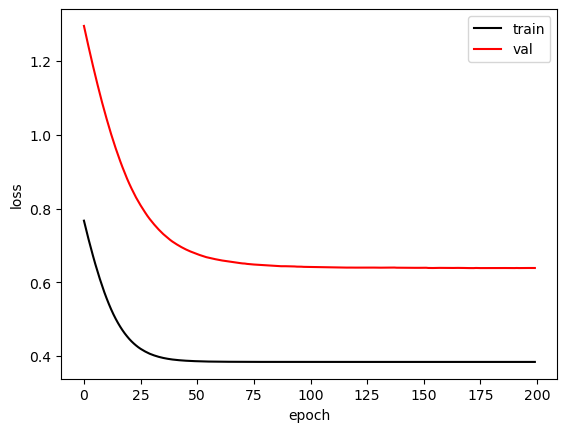

final train mae: 0.384
final val mae:   0.639


In [27]:
# Build model using SGD with one feature -- cumulative total emissions
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model = build_model_linear(optimizer)

history = model.fit(
  x = x_train['cum_sum_total_emission'],
  y = Y_train,
  validation_data=(x_val['cum_sum_total_emission'],Y_val),  
  epochs=200,
  batch_size=150,
  verbose=0)

show_history(history)

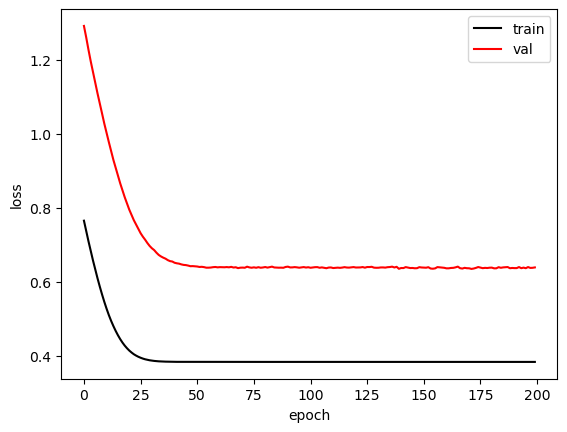

final train mae: 0.384
final val mae:   0.639


In [28]:
# Build model using Adam with one feature -- cumulative total emissions
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model_linear(optimizer)

history = model.fit(
  x = x_train['cum_sum_total_emission'],
  y = Y_train,
  validation_data=(x_val['cum_sum_total_emission'],Y_val),  
  epochs=200,
  batch_size=150,
  verbose=0)

show_history(history)

### Baseline Linear Regression - Functional API

In [29]:
def build_model_linear_api():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)

  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='sum_total_emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(sum_total_emissions)

  model = tf.keras.Model(inputs=sum_total_emissions,
                         outputs=temp,
                         name='Linear')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_absolute_error'
      )

  return model

Model: "Linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sum_total_emissions (InputL  [(None, 1)]              0         
 ayer)                                                           
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


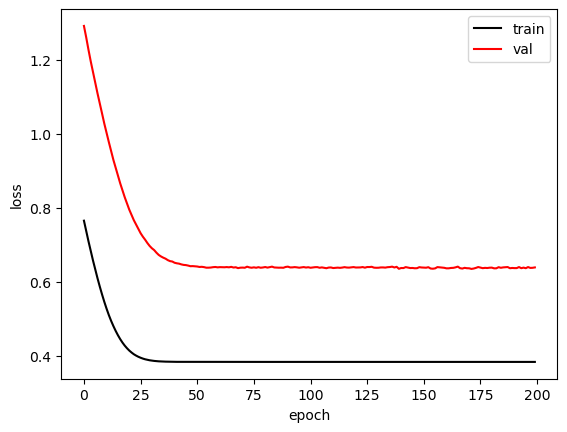

final train mae: 0.384
final val mae:   0.639


In [30]:
model = build_model_linear_api()
model.summary()

history = model.fit(
  x=x_train[['cum_sum_total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=200,
  batch_size=150,
  validation_data=(
      x_val[['cum_sum_total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Linear regression with all log sum input features

In [31]:
def build_model_linear_api_sum():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)

  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # concatenate input features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions])


  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions],
                         outputs=temp,
                         name='Linear')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
      loss='mean_absolute_error'
      )

  return model

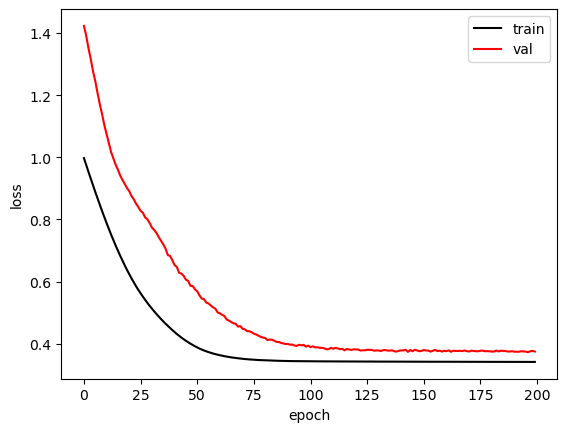

final train mae: 0.341
final val mae:   0.375


In [32]:
model = build_model_linear_api_sum()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
    },
  y=Y_train,
  epochs=200,
  batch_size=200,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
      },
      Y_val),
  verbose=0)

show_history(history)

### Linear regression with all log sum input features + one-hot of sub-regions

In [33]:
def build_model_linear_api_sum_subreg():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)

  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')

  # one-hot encoding for sub-regions
  sub_region_id = tf.keras.layers.StringLookup(
      vocabulary=sub_regions, output_mode='one_hot')(sub_region)

  # concatenate input features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions, sub_region_id])


  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions, sub_region],
                         outputs=temp,
                         name='Linear')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_absolute_error'
      )

  return model

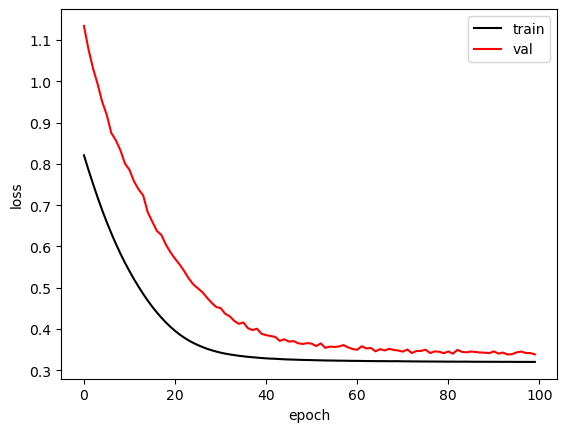

final train mae: 0.320
final val mae:   0.338


In [34]:
model = build_model_linear_api_sum_subreg()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'sub-region': x_train[['sub-region']]
    },
  y=Y_train,
  epochs=100,
  batch_size=300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'sub-region': x_val[['sub-region']]
      },
      Y_val),
  verbose=0)

show_history(history)

### Linear regression with all sum input features + one-hot of sub-regions + learning rate decay

In [35]:
def build_model_linear_api_sum_subreg_lr():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)

  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')

  # one-hot encoding for sub-regions
  sub_region_id = tf.keras.layers.StringLookup(
      vocabulary=sub_regions, output_mode='one_hot')(sub_region)

  # concatenate input features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions, sub_region_id])


  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions, sub_region],
                         outputs=temp,
                         name='Linear')
  
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss='mean_absolute_error'
      )


  return model

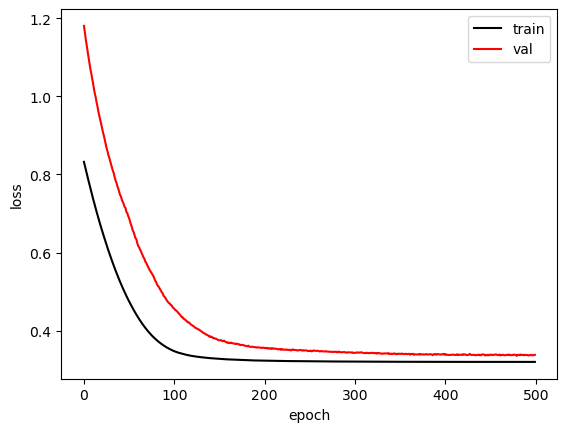

final train mae: 0.320
final val mae:   0.338


In [36]:
initial_learning_rate = 0.001


model = build_model_linear_api_sum_subreg_lr()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'sub-region': x_train[['sub-region']]
    },
  y=Y_train,
  epochs=500,
  batch_size=100,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'sub-region': x_val[['sub-region']]
      },
      Y_val),
  verbose=0)

show_history(history)

### Compute MAE on test data:

In [37]:
lin_log_sum_preds = model.predict(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'sub-region': x_test[['sub-region']]
    })

18/18 [==============================] - 0s 733us/step


In [38]:
model.evaluate(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'sub-region': x_test[['sub-region']]
    },
  y=Y_test)

18/18 [==============================] - 0s 901us/step - loss: 0.4181


0.4181180000305176

### Plot graph of predicted vs. actual

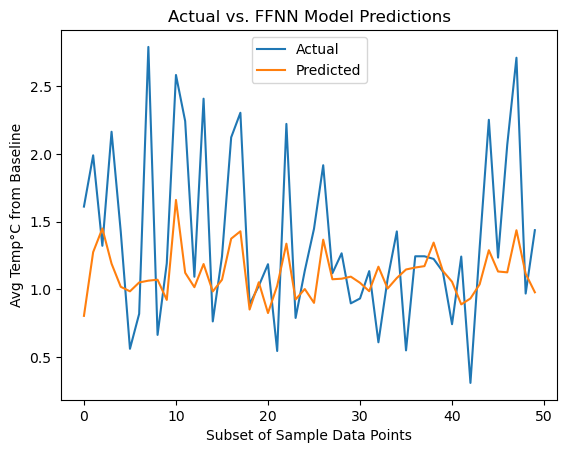

In [39]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], lin_log_sum_preds[0:50])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))

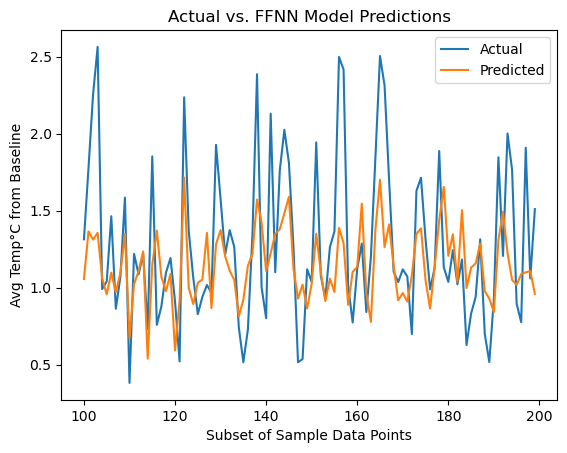

In [40]:
plt.plot(Y_test.index[100:200], Y_test.values[100:200])
plt.plot(Y_test.index[100:200], lin_log_sum_preds[100:200])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))

### Hyperparameter Tuning -- plots for slides

### Changing batch size

In [41]:
# Faye's Final Linear Regression Model

def build_model_5b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas,
                                               output_mode='one_hot')(area)
    
  features = tf.keras.layers.Concatenate()([mei,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            sub_region_id,
                                            area_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[mei,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_5b')
    
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

In [42]:
# store train and validation loss curves for models with different parameters -- changing batch sizes
model_5b = build_model_5b()

history_5b = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=150,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss = pd.DataFrame(history_5b.history['loss'], columns=['final'])
linear_df_val_loss = pd.DataFrame(history_5b.history['val_loss'], columns=['final'])

In [43]:
# store train and validation loss curves for models with different parameters -- changing batch sizes
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b()

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=150,
  batch_size=100,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['100'] = history.history['loss']
linear_df_val_loss['100'] = history.history['val_loss']

In [44]:
# store train and validation loss curves for models with different parameters -- changing batch sizes

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b()

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=150,
  batch_size=200,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['200'] = history.history['loss']
linear_df_val_loss['200'] = history.history['val_loss']

In [45]:
# store train and validation loss curves for models with different parameters -- changing batch sizes

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b()

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=150,
  batch_size=800,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['800'] = history.history['loss']
linear_df_val_loss['800'] = history.history['val_loss']

In [46]:
linear_df_train_loss.rename(columns = {'final': 'final (400)'}, inplace = True)
linear_df_train_loss = linear_df_train_loss[['100', '200', 'final (400)', '800']]

In [47]:
linear_df_val_loss.rename(columns = {'final': 'final (400)'}, inplace = True)
linear_df_val_loss = linear_df_val_loss[['100', '200', 'final (400)', '800']]

In [48]:
def create_line_plot(df):
    plt.figure(figsize=(6, 4))

    # Plot each column
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    # Set labels and title
    plt.xlabel('loss')
    plt.ylabel('epochs')

    # Display legend
    plt.legend(title='Batch size:')

    # Display the plot
    plt.show()

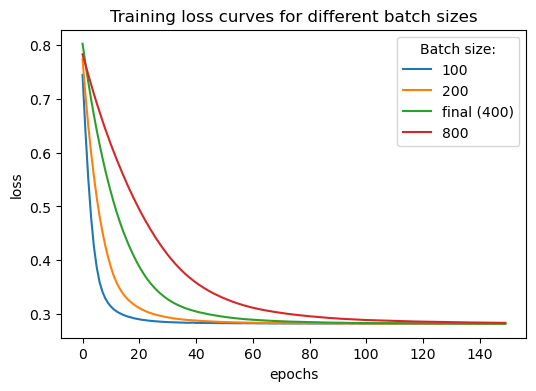

In [49]:
plt.figure(figsize=(6, 4))

# Plot each column
for column in linear_df_train_loss.columns:
    plt.plot(linear_df_train_loss.index, linear_df_train_loss[column], label=column)

# Set labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss curves for different batch sizes')

# Display legend
plt.legend(title='Batch size:')

# Display the plot
plt.show()

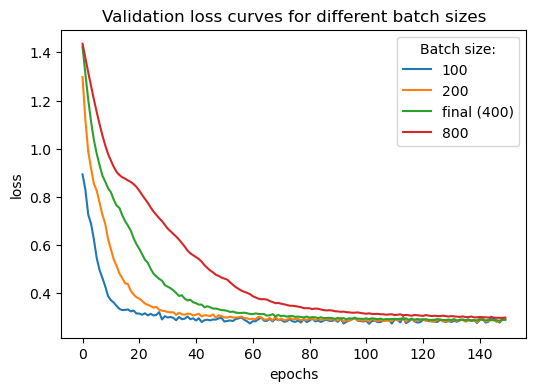

In [50]:
plt.figure(figsize=(6, 4))

# Plot each column
for column in linear_df_val_loss.columns:
    plt.plot(linear_df_val_loss.index, linear_df_val_loss[column], label=column)

# Set labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation loss curves for different batch sizes')

# Display legend
plt.legend(title='Batch size:')

# Display the plot
plt.show()

### Changing learning rate

In [51]:
# Faye's Final Linear Regression Model modified for learning rate input

def build_model_5b(learning_rate):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas,
                                               output_mode='one_hot')(area)
    
  features = tf.keras.layers.Concatenate()([mei,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            sub_region_id,
                                            area_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[mei,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_5b')
        
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

In [52]:
# store train and validation loss curves for models with different parameters -- changing learning rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b(lr_schedule)

history_5b = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss = pd.DataFrame(history_5b.history['loss'], columns=['final'])
linear_df_val_loss = pd.DataFrame(history_5b.history['val_loss'], columns=['final'])

In [53]:
# store train and validation loss curves for models with different parameters -- changing learning rate
model_5b = build_model_5b(0.001)

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)


linear_df_train_loss['0.001'] = history.history['loss']
linear_df_val_loss['0.001'] = history.history['val_loss']

In [54]:
# store train and validation loss curves for models with different parameters -- changing learning rate

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b(lr_schedule)

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['0.0001+'] = history.history['loss']
linear_df_val_loss['0.0001+'] = history.history['val_loss']

In [55]:
# store train and validation loss curves for models with different parameters -- changing learning rate

model_5b = build_model_5b(0.0001)

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['0.0001'] = history.history['loss']
linear_df_val_loss['0.0001'] = history.history['val_loss']

In [56]:
# store train and validation loss curves for models with different parameters -- changing learning rate

model_5b = build_model_5b(0.00001)

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['0.00001'] = history.history['loss']
linear_df_val_loss['0.00001'] = history.history['val_loss']

In [57]:
# store train and validation loss curves for models with different parameters -- changing learning rate

initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_5b = build_model_5b(lr_schedule)

history = model_5b.fit(
  x={
      'MEI': x_train[['mei']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=400,
  batch_size=400,
  validation_data=(
      {
      'MEI': x_val[['mei']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

linear_df_train_loss['0.00001+'] = history.history['loss']
linear_df_val_loss['0.00001+'] = history.history['val_loss']

In [58]:
# rename and change order for plotting
linear_df_train_loss.rename(columns = {'final': 'final (0.001+)'}, inplace = True)
linear_df_train_loss = linear_df_train_loss[['0.001', 'final (0.001+)', '0.0001', '0.0001+', '0.00001', '0.00001+']]

In [59]:
linear_df_val_loss.rename(columns = {'final': 'final (0.001+)'}, inplace = True)
linear_df_val_loss = linear_df_val_loss[['0.001', 'final (0.001+)', '0.0001', '0.0001+', '0.00001', '0.00001+']]

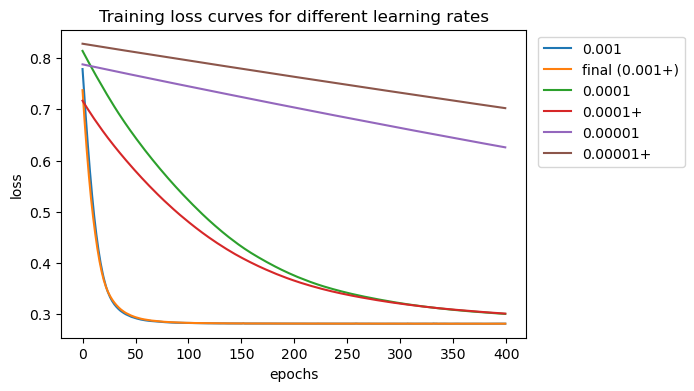

In [60]:
plt.figure(figsize=(6, 4))

# Plot each column
for column in linear_df_train_loss.columns:
    plt.plot(linear_df_train_loss.index, linear_df_train_loss[column], label=column)

# Set labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss curves for different learning rates')

# Display legend
plt.legend(title='Learning rate:')

# Change legend position
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Display the plot
plt.show()

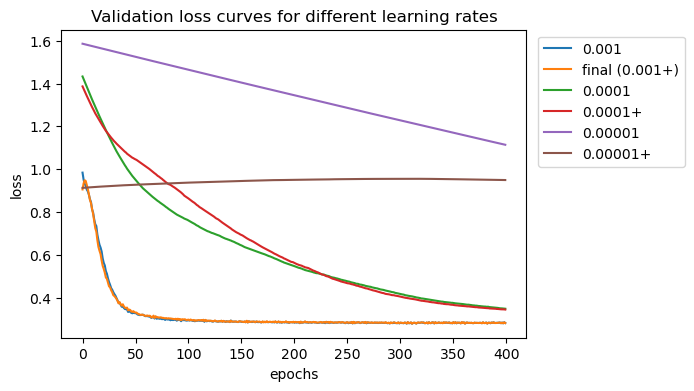

In [61]:
plt.figure(figsize=(6, 4))

# Plot each column
for column in linear_df_val_loss.columns:
    plt.plot(linear_df_val_loss.index, linear_df_val_loss[column], label=column)

# Set labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation loss curves for different learning rates')

# Display legend
plt.legend(title='Learning rates:')

# Change legend position
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Display the plot
plt.show()

### Hyperparameters experimentation

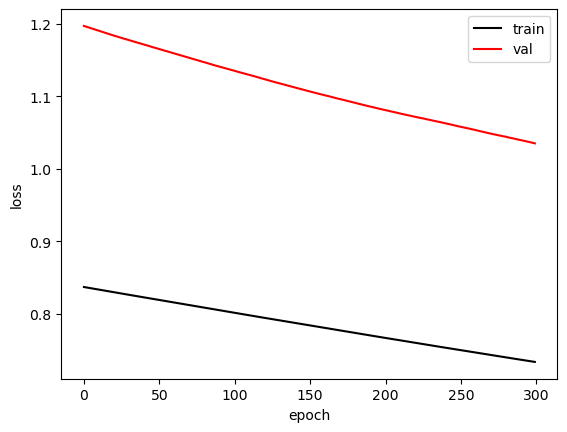

final train mae: 0.734
final val mae:   1.035


In [62]:
initial_learning_rate = 0.001


model = build_model_linear_api_sum_subreg_lr()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'sub-region': x_train[['sub-region']]
    },
  y=Y_train,
  epochs=300,
  batch_size=300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'sub-region': x_val[['sub-region']]
      },
      Y_val),
  verbose=0)

show_history(history)

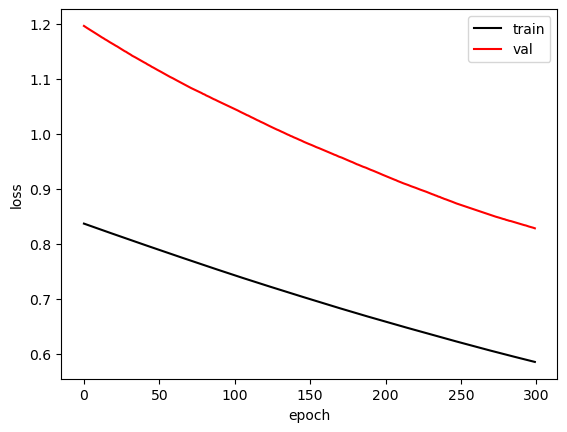

final train mae: 0.585
final val mae:   0.828


In [63]:
initial_learning_rate = 0.0001


model = build_model_linear_api_sum_subreg_lr()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'sub-region': x_train[['sub-region']]
    },
  y=Y_train,
  epochs=300,
  batch_size=100,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'sub-region': x_val[['sub-region']]
      },
      Y_val),
  verbose=0)

show_history(history)

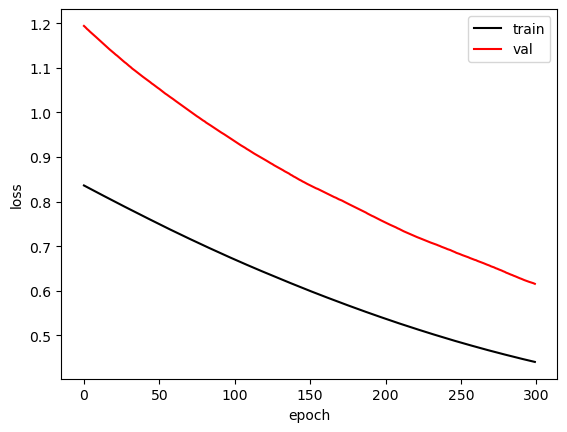

final train mae: 0.440
final val mae:   0.615


In [64]:
initial_learning_rate = 0.00001


model = build_model_linear_api_sum_subreg_lr()


history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'sub-region': x_train[['sub-region']]
    },
  y=Y_train,
  epochs=300,
  batch_size=50,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'sub-region': x_val[['sub-region']]
      },
      Y_val),
  verbose=0)

show_history(history)

### FNN with Embeddings

In [65]:
# following Titanic example to create embeddings
region = np.array(x_train['region'])

region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
print('Region ids:', region_binned)

region_embed = tf.keras.layers.Embedding(
    input_dim=6, output_dim=5, input_length=1)(region_binned)
print('Region embeddings:', region_embed)

Region ids: tf.Tensor([3 4 1 ... 3 1 1], shape=(4681,), dtype=int64)
Region embeddings: tf.Tensor(
[[ 0.03812068 -0.04309607  0.02266448 -0.03432025  0.03625369]
 [-0.02141934  0.03982611 -0.01945094 -0.03684648 -0.01933975]
 [-0.01590468 -0.01725948 -0.00446265 -0.02832458 -0.01780082]
 ...
 [ 0.03812068 -0.04309607  0.02266448 -0.03432025  0.03625369]
 [-0.01590468 -0.01725948 -0.00446265 -0.02832458 -0.01780082]
 [-0.01590468 -0.01725948 -0.00446265 -0.02832458 -0.01780082]], shape=(4681, 5), dtype=float32)


### FNN Model with embeddings -- 1 hidden layer

use all available agricultural features and MEI + region + year

In [66]:
def build_model_embed_1():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # embeddings
  region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='region')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')
  year = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='year')

  embed_dim = 5

  region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  year_binned = tf.keras.layers.IntegerLookup(vocabulary=years)(year) 

  region_embed = tf.keras.layers.Embedding(
      input_dim=6, output_dim=embed_dim, input_length=1)(region_binned)
  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  year_embed = tf.keras.layers.Embedding(
      input_dim=26, output_dim=embed_dim, input_length=1)(year_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [region_embed, sub_region_embed, year_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions,
       flat_embed])
  
  dense1 = tf.keras.layers.Dense(
      units=100, activation='relu', name='hidden1')(features)
 
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(dense1)

  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sum_total_emissions, 
                            region, sub_region, year],
                         outputs=temp,
                         name='Model')

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='mean_absolute_error'
      )
      
  return model

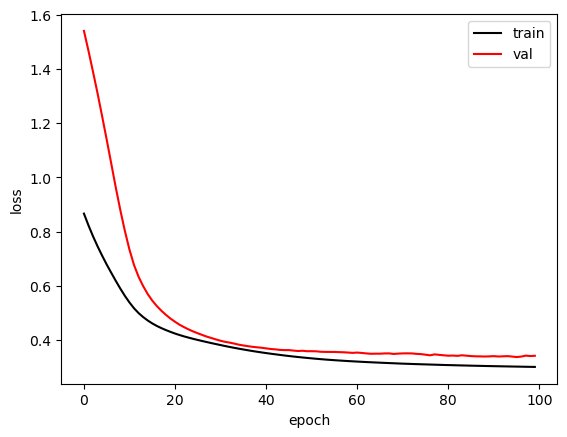

final train mae: 0.301
final val mae:   0.342


In [67]:
model = build_model_embed_1()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=100,
  batch_size=500,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### FNN with embeddings -- two hidden layers

In [68]:
def build_model_embed_2(learning_rate):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # embeddings
  region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='region')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')
  year = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='year')

  embed_dim = 5

  region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  year_binned = tf.keras.layers.IntegerLookup(vocabulary=years)(year) 

  region_embed = tf.keras.layers.Embedding(
      input_dim=6, output_dim=embed_dim, input_length=1)(region_binned)
  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  year_embed = tf.keras.layers.Embedding(
      input_dim=26, output_dim=embed_dim, input_length=1)(year_binned)


  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [region_embed, sub_region_embed, year_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions,
       flat_embed])
  
  dense1 = tf.keras.layers.Dense(
      units=100, activation='relu', name='hidden1')(features)

  dense2 = tf.keras.layers.Dense(
      units=100, activation='relu', name='hidden2')(dense1)
  
  merged = tf.keras.layers.Concatenate()([dense1, dense2])
 
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(merged)

#   temp = tf.keras.layers.Dense(
#       units=1, activation=None, name='Temp')(dense2)

  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sum_total_emissions, 
                            region, sub_region, year],
                         outputs=temp,
                         name='Model')

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='mean_absolute_error'
      )
      
  return model

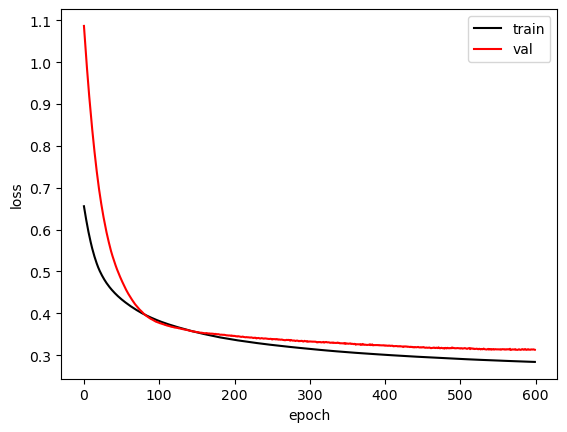

final train mae: 0.284
final val mae:   0.313


In [69]:
model = build_model_embed_2(0.00001)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=600,
  batch_size=300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

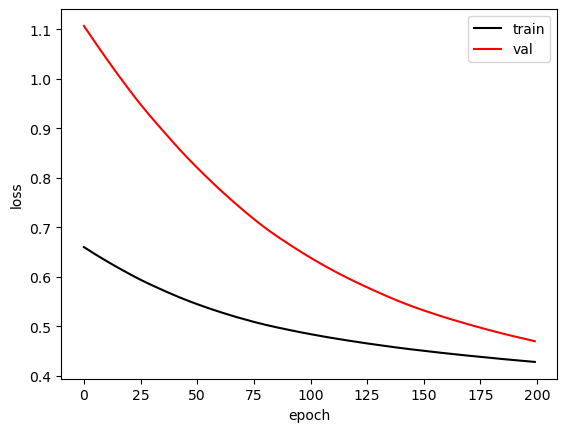

final train mae: 0.428
final val mae:   0.470


In [70]:
initial_learning_rate = 0.000001
model = build_model_embed_2(lr_schedule)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=200,
  batch_size=1300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### FNN with embeddings -- two hidden layers + dropout

#### experimenting with fewer units in layers

In [71]:
def build_model_embed_2_drop(learning_rate):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # embeddings
  region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='region')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')
  year = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='year')

  embed_dim = 5

  region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  year_binned = tf.keras.layers.IntegerLookup(vocabulary=years)(year) 

  region_embed = tf.keras.layers.Embedding(
      input_dim=6, output_dim=embed_dim, input_length=1)(region_binned)
  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  year_embed = tf.keras.layers.Embedding(
      input_dim=26, output_dim=embed_dim, input_length=1)(year_binned)


  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [region_embed, sub_region_embed, year_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions,
       flat_embed])

  dense1 = tf.keras.layers.Dense(
    units=50, activation='relu', name='hidden1')(features)

  dense2 = tf.keras.layers.Dense(
    units=50, activation='relu', name='hidden2')(dense1)
 
#   add a dropout layer
  dropout_layer = tf.keras.layers.Dropout(rate=0.1)(dense2)
  
#   temp = tf.keras.layers.Dense(
#       units=1, activation=None, name='Temp')(dense2)

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(dropout_layer)


  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sum_total_emissions, 
                            region, sub_region, year],
                         outputs=temp,
                         name='Model')

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='mean_absolute_error'
      )
      
  return model

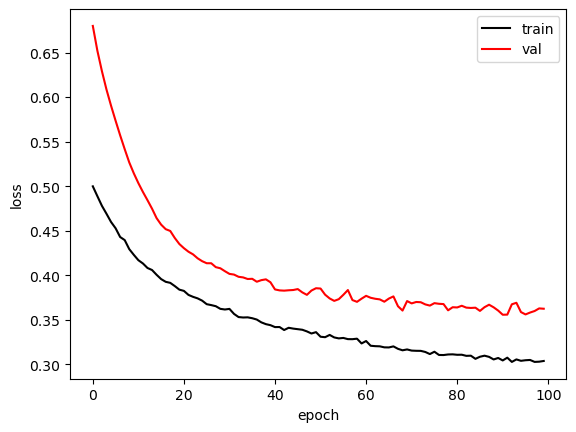

final train mae: 0.304
final val mae:   0.362


In [72]:
model = build_model_embed_2_drop(0.0001)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=100,
  batch_size=500,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### adding units back in

In [73]:
def build_model_embed_2_drop(learning_rate, drop_rate=0.1):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # embeddings
  region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='region')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')
  year = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='year')

  embed_dim = 5

  region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  year_binned = tf.keras.layers.IntegerLookup(vocabulary=years)(year) 

  region_embed = tf.keras.layers.Embedding(
      input_dim=6, output_dim=embed_dim, input_length=1)(region_binned)
  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  year_embed = tf.keras.layers.Embedding(
      input_dim=26, output_dim=embed_dim, input_length=1)(year_binned)


  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [region_embed, sub_region_embed, year_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions,
       flat_embed])

  dense1 = tf.keras.layers.Dense(
    units=100, activation='relu', name='hidden1')(features)

  dense2 = tf.keras.layers.Dense(
    units=100, activation='relu', name='hidden2')(dense1)
 
#   add a dropout layer
  dropout_layer = tf.keras.layers.Dropout(rate=drop_rate)(dense2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(dropout_layer)


  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sum_total_emissions, 
                            region, sub_region, year],
                         outputs=temp,
                         name='Model')

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='mean_absolute_error'
      )
      
  return model

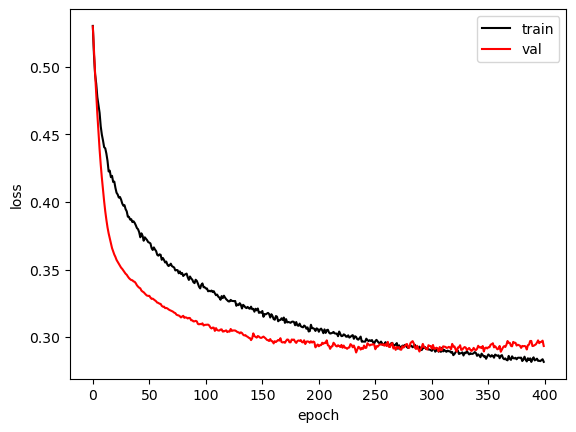

final train mae: 0.282
final val mae:   0.293


In [74]:
model = build_model_embed_2_drop(0.00001)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=400,
  batch_size=100,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### MAE of test data with 2 layer FNN

In [75]:
fnn_2layer_preds = model.predict(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'region': x_test[['region']],
      'sub-region': x_test[['sub-region']],
      'year': x_test[['year']]
    })

18/18 [==============================] - 0s 1ms/step


In [76]:
model.evaluate(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'region': x_test[['region']],
      'sub-region': x_test[['sub-region']],
      'year': x_test[['year']]
    },
    y = Y_test)

18/18 [==============================] - 0s 1ms/step - loss: 0.3898


0.38981959223747253

### Plot graph of predicted vs. actual

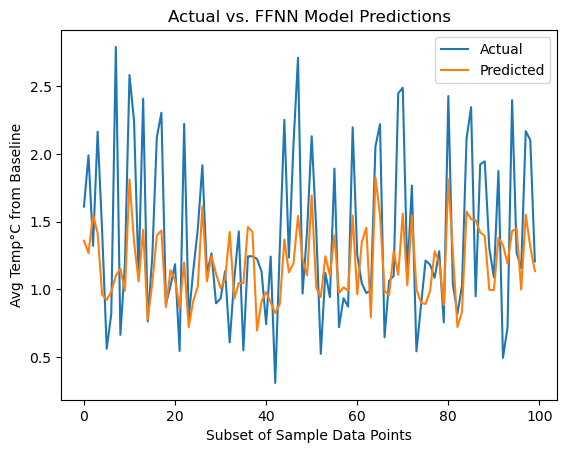

In [77]:
plt.plot(Y_test.index[0:100], Y_test.values[0:100])
plt.plot(Y_test.index[0:100], fnn_2layer_preds[0:100])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

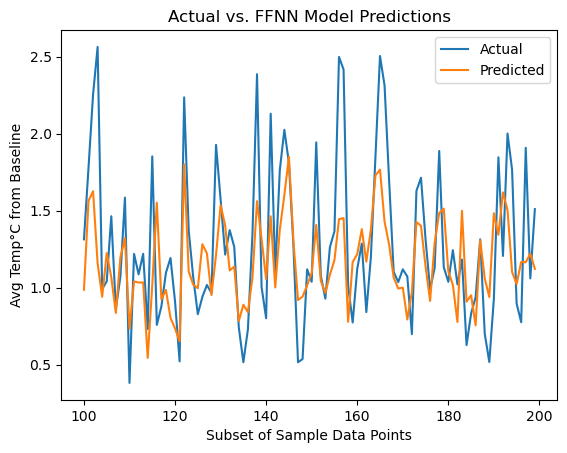

In [78]:
plt.plot(Y_test.index[100:200], Y_test.values[100:200])
plt.plot(Y_test.index[100:200], fnn_2layer_preds[100:200])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

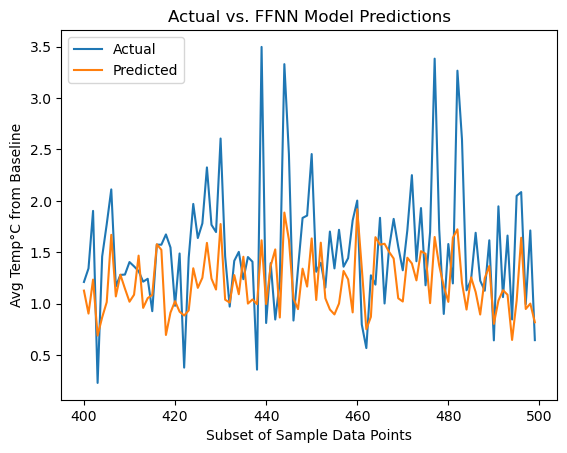

In [79]:
plt.plot(Y_test.index[400:500], Y_test.values[400:500])
plt.plot(Y_test.index[400:500], fnn_2layer_preds[400:500])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

### Other Hyperparameters

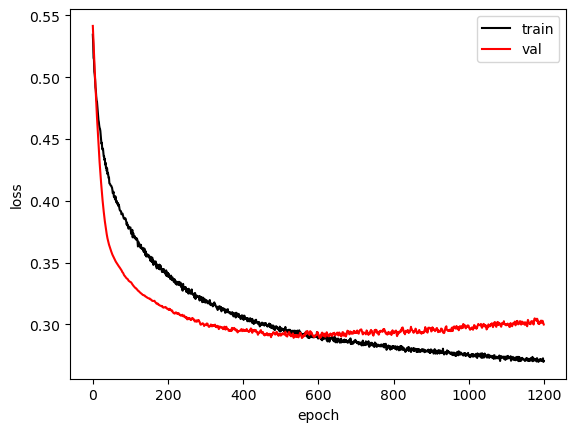

final train mae: 0.270
final val mae:   0.300


In [80]:
model = build_model_embed_2_drop(0.00001)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=1200,
  batch_size=300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

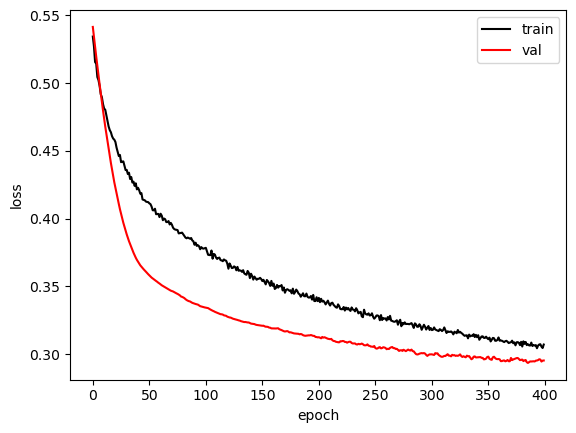

final train mae: 0.307
final val mae:   0.295


In [81]:
initial_learning_rate = 0.000001
model = build_model_embed_2_drop(lr_schedule)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=400,
  batch_size=300,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

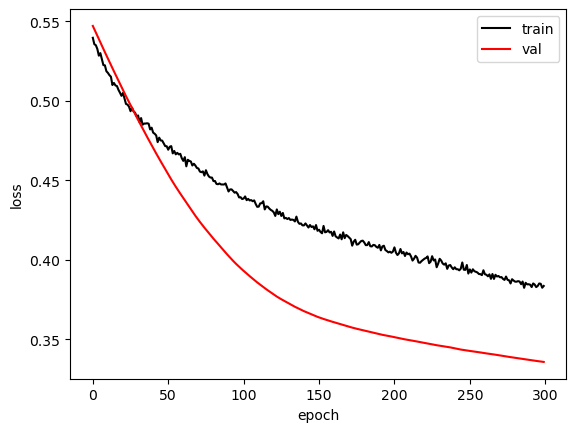

final train mae: 0.384
final val mae:   0.336


In [82]:
initial_learning_rate = 0.000001
model = build_model_embed_2_drop(lr_schedule)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=300,
  batch_size=1200,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

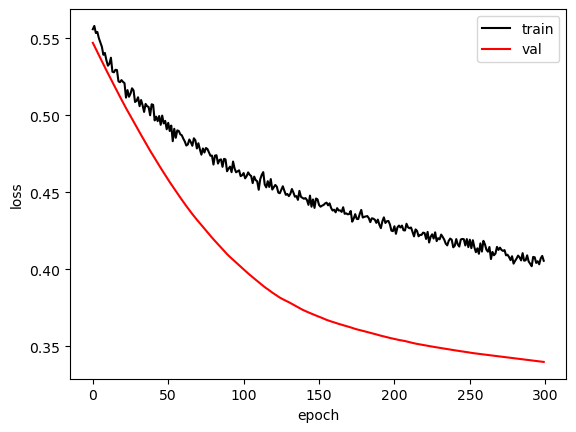

final train mae: 0.406
final val mae:   0.340


In [83]:
initial_learning_rate = 0.000001
model = build_model_embed_2_drop(lr_schedule, drop_rate=0.3)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=300,
  batch_size=1200,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

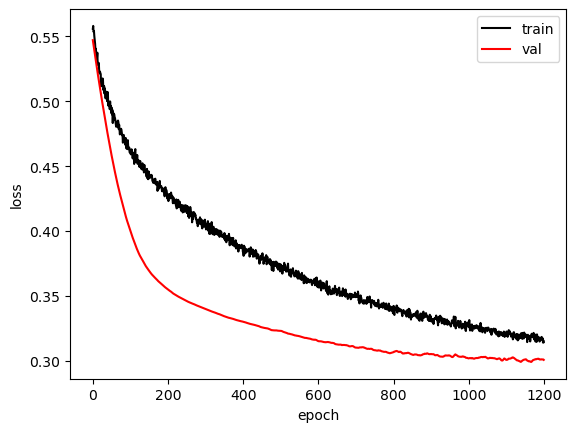

final train mae: 0.314
final val mae:   0.301


In [84]:
initial_learning_rate = 0.0000001
model = build_model_embed_2_drop(lr_schedule, drop_rate=0.3)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=1200,
  batch_size=1200,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

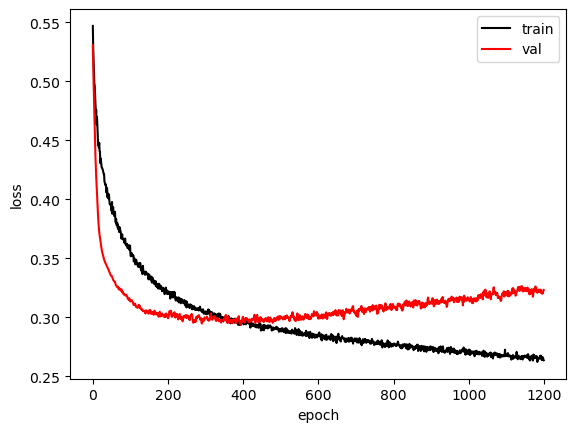

final train mae: 0.264
final val mae:   0.323


In [85]:
initial_learning_rate = 0.00001
model = build_model_embed_2_drop(lr_schedule, drop_rate=0.3)

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=1200,
  batch_size=100,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### FNN with embeddings -- 3 hidden layers and dropout

In [86]:
def build_model_embed_3(learning_rate, drop_rate=0.1):
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='mei')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_crop_residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_rice_cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_drained_organic_soils_co2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_net_forest_conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_manure_mgmt')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_food_systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_ippu_tot')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_log_on_farm_energy_use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_forestland')
  sum_total_emissions = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='cum_sum_total_emission')

  # embeddings
  region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='region')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='sub-region')
  year = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='year')

  embed_dim = 5

  region_binned = tf.keras.layers.StringLookup(vocabulary=regions)(region)
  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  year_binned = tf.keras.layers.IntegerLookup(vocabulary=years)(year) 

  region_embed = tf.keras.layers.Embedding(
      input_dim=6, output_dim=embed_dim, input_length=1)(region_binned)
  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  year_embed = tf.keras.layers.Embedding(
      input_dim=26, output_dim=embed_dim, input_length=1)(year_binned)


  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [region_embed, sub_region_embed, year_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland, sum_total_emissions,
       flat_embed])

  dense1 = tf.keras.layers.Dense(
    units=100, activation='relu', name='hidden1')(features)

  dense2 = tf.keras.layers.Dense(
    units=100, activation='relu', name='hidden2')(dense1)
 
  dense3 = tf.keras.layers.Dense(
    units=100, activation='relu', name='hidden3')(dense2)

#   add a dropout layer
  dropout_layer = tf.keras.layers.Dropout(rate=drop_rate)(dense3)

#   dense3 = tf.keras.layers.Dense(
#     units=100, activation='relu', name='hidden3')(dropout_layer)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(dropout_layer)
  

#   temp = tf.keras.layers.Dense(
#       units=1, activation=None, name='Temp')(dense3)


  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sum_total_emissions, 
                            region, sub_region, year],
                         outputs=temp,
                         name='Model')

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='mean_absolute_error'
      )
      
  return model

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sub-region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['region[0][0]']                 
                                                                                              

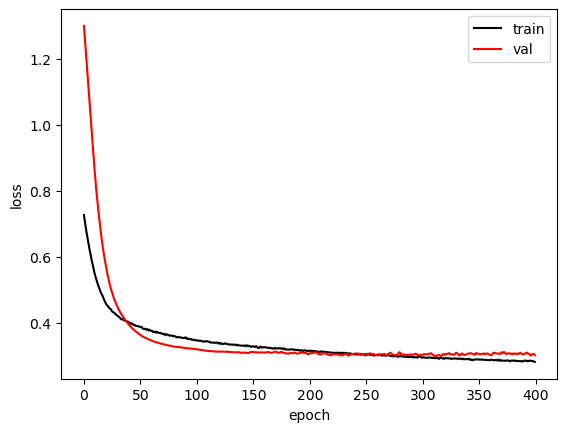

final train mae: 0.281
final val mae:   0.301


In [87]:
model = build_model_embed_3(0.00002)
model.summary()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=400,
  batch_size=500,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

In [88]:
fnn_3layer_preds = model.predict(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'region': x_test[['region']],
      'sub-region': x_test[['sub-region']],
      'year': x_test[['year']]
    })

18/18 [==============================] - 0s 922us/step


In [89]:
model.evaluate(
  x={
      'mei': x_test[['mei']],
      'cum_sum_log_crop_residues': x_test[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_test[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_test[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_test[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_test[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_test[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_test[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_test[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_test[['cum_sum_total_emission']],
      'region': x_test[['region']],
      'sub-region': x_test[['sub-region']],
      'year': x_test[['year']]
    },
    y = Y_test)

18/18 [==============================] - 0s 948us/step - loss: 0.3892


0.38918906450271606

### Plot graph of predicted vs. actual

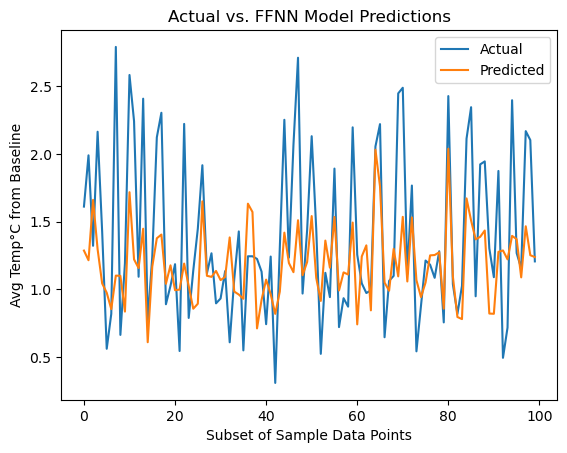

In [90]:
plt.plot(Y_test.index[0:100], Y_test.values[0:100])
plt.plot(Y_test.index[0:100], fnn_3layer_preds[0:100])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

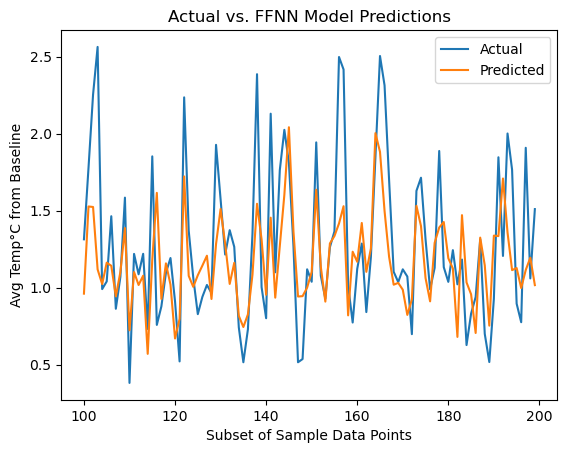

In [91]:
plt.plot(Y_test.index[100:200], Y_test.values[100:200])
plt.plot(Y_test.index[100:200], fnn_3layer_preds[100:200])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

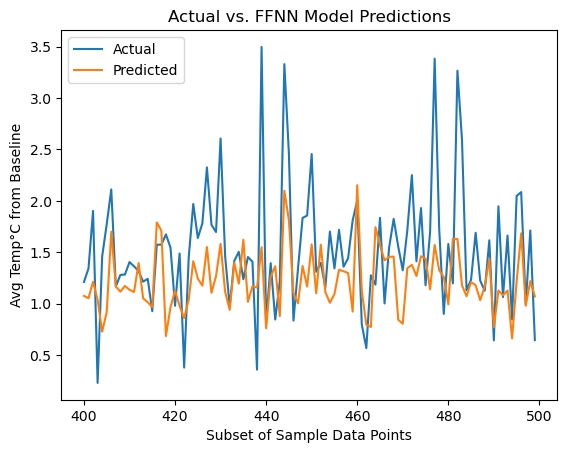

In [92]:
plt.plot(Y_test.index[400:500], Y_test.values[400:500])
plt.plot(Y_test.index[400:500], fnn_3layer_preds[400:500])
plt.ylabel('Avg Temp°C from Baseline')
plt.xlabel('Subset of Sample Data Points')
plt.title('Actual vs. FFNN Model Predictions')
plt.legend(('Actual', 'Predicted'))
plt.show()

### Other Hyperparameters

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sub-region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['region[0][0]']                 
                                                                                              

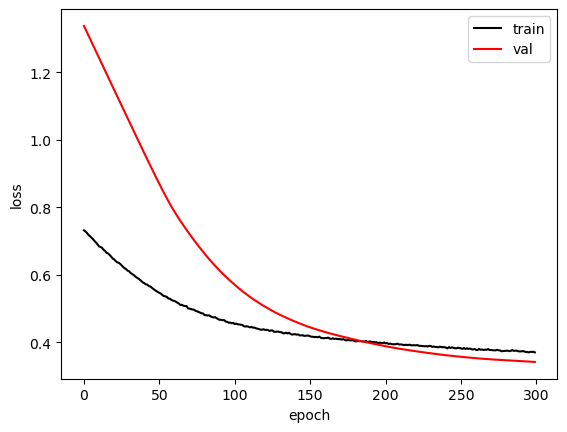

final train mae: 0.370
final val mae:   0.342


In [93]:
initial_learning_rate = 0.000001
model = build_model_embed_3(lr_schedule)
model.summary()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=300,
  batch_size=1200,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sub-region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['region[0][0]']                 
                                                                                              

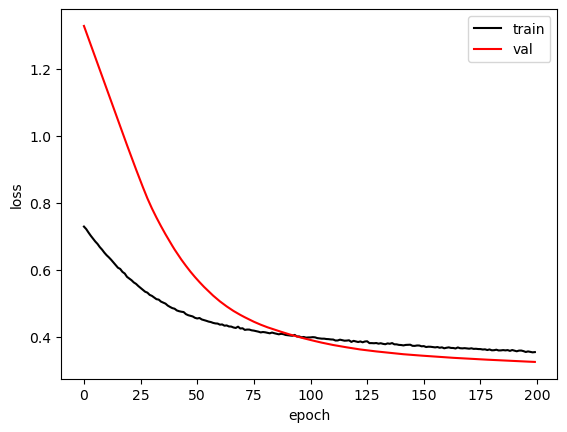

final train mae: 0.355
final val mae:   0.326


In [94]:
initial_learning_rate = 0.00002
model = build_model_embed_3(lr_schedule)
model.summary()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=200,
  batch_size=600,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sub-region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['region[0][0]']                 
                                                                                              

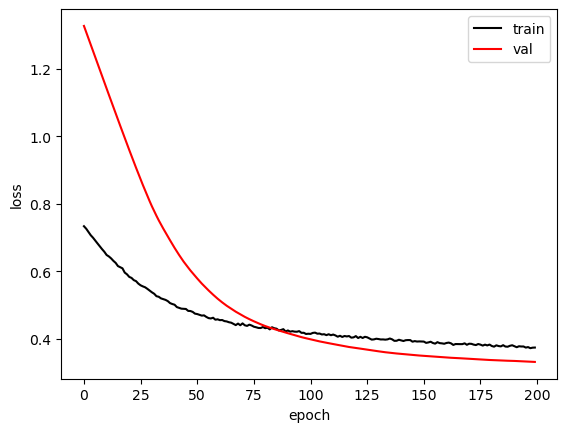

final train mae: 0.374
final val mae:   0.331


In [95]:
initial_learning_rate = 0.00002
model = build_model_embed_3(lr_schedule, drop_rate=0.3)
model.summary()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=200,
  batch_size=600,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sub-region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 year (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['region[0][0]']                 
                                                                                              

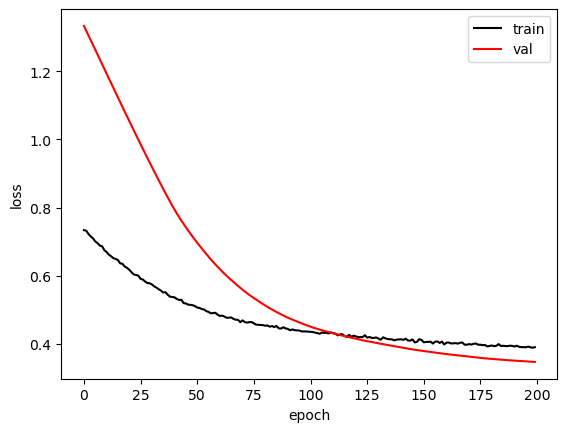

final train mae: 0.391
final val mae:   0.348


In [96]:
initial_learning_rate = 0.000001
model = build_model_embed_3(lr_schedule, drop_rate=0.3)
model.summary()

history = model.fit(
  x={
      'mei': x_train[['mei']],
      'cum_sum_log_crop_residues': x_train[['cum_sum_log_crop_residues']],
      'cum_sum_log_rice_cultivation': x_train[['cum_sum_log_rice_cultivation']], 
      'cum_sum_log_drained_organic_soils_co2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'cum_sum_log_net_forest_conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'cum_sum_log_fires': x_train[['cum_sum_log_fires']],
      'cum_sum_log_manure_mgmt': x_train[['cum_sum_log_manure_mgmt']], 
      'cum_sum_log_food_systems': x_train[['cum_sum_log_food_systems']],
      'cum_sum_log_ippu_tot': x_train[['cum_sum_log_ippu_tot']], 
      'cum_sum_log_on_farm_energy_use': x_train[['cum_sum_log_on_farm_energy_use']],
      'cum_sum_forestland': x_train[['cum_sum_forestland']], 
      'cum_sum_total_emission': x_train[['cum_sum_total_emission']],
      'region': x_train[['region']],
      'sub-region': x_train[['sub-region']],
      'year': x_train[['year']]
    },
  y=Y_train,
  epochs=200,
  batch_size=800,
  validation_data=(
      {
        'mei': x_val[['mei']],
        'cum_sum_log_crop_residues': x_val[['cum_sum_log_crop_residues']],
        'cum_sum_log_rice_cultivation': x_val[['cum_sum_log_rice_cultivation']], 
        'cum_sum_log_drained_organic_soils_co2': x_val[['cum_sum_log_drained_organic_soils_co2']],
        'cum_sum_log_net_forest_conversion': x_val[['cum_sum_log_net_forest_conversion']],
        'cum_sum_log_fires': x_val[['cum_sum_log_fires']],
        'cum_sum_log_manure_mgmt': x_val[['cum_sum_log_manure_mgmt']], 
        'cum_sum_log_food_systems': x_val[['cum_sum_log_food_systems']],
        'cum_sum_log_ippu_tot': x_val[['cum_sum_log_ippu_tot']], 
        'cum_sum_log_on_farm_energy_use': x_val[['cum_sum_log_on_farm_energy_use']],
        'cum_sum_forestland': x_val[['cum_sum_forestland']], 
        'cum_sum_total_emission': x_val[['cum_sum_total_emission']],
        'region': x_val[['region']],
        'sub-region': x_val[['sub-region']],
        'year': x_val[['year']],
      },
      Y_val),
  verbose=0)

show_history(history)

### Hyperparameter tuning plots for slides

In [97]:
def build_model_8b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  # embeddings
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  embed_dim = 5

  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  area_binned = tf.keras.layers.StringLookup(vocabulary=areas)(area)

  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  area_embed = tf.keras.layers.Embedding(
      input_dim=191, output_dim=embed_dim, input_length=1)(area_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [sub_region_embed, area_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  #Concatenate with other features
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            flat_embed])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_2)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_8b')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_8b"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sub Region (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Area (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['Sub Region[0][0]']             
                                                                                                  
 string_lookup_1 (StringLookup)  (None, 1)           0           ['Area[0][0]']                   
                                                                                           

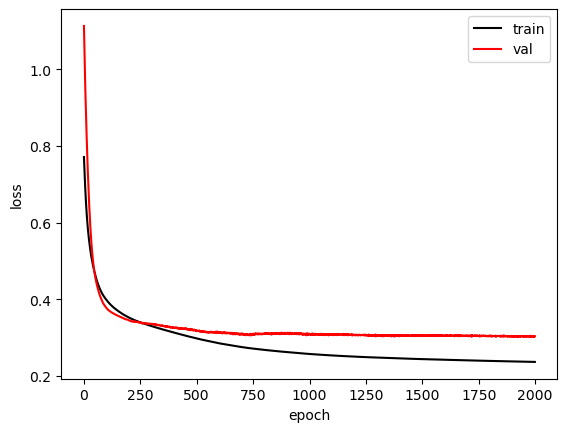

final train mae: 0.236
final val mae:   0.303


In [98]:
model_8b = build_model_8b()
model_8b.summary()

history_8b = model_8b.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=500,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_8b)

In [99]:
model_8b.evaluate(
  x={
      'Urban Population': x_test[['urban_population']],
      'MEI': x_test[['mei']],
      'Crop Residues': x_test[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_test[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'Fires': x_test[['cum_sum_log_fires']],
      'Manure Management': x_test[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_test[['cum_sum_log_food_systems']],
      'IPPU Total': x_test[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_test[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_test[['cum_sum_forestland']],
      'Sub Region': x_test[['sub-region']],
      'Area': x_test[['area']]
    },
    y = Y_test)

18/18 [==============================] - 0s 1ms/step - loss: 0.4256 - root_mean_squared_error: 0.5339


[0.4255676567554474, 0.5338989496231079]